## MCC NMIBC Pre-repeat Urine MRD analysis

In [44]:
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(maftools)
library(RColorBrewer)
library(readxl)
library(stats)
library(pROC)
library(stringr)
source("~/Desktop/puffin/R/helper_functions.R")
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=50)
source("../fix_PIDs.R")

print(Sys.time())
print(sessionInfo())

[1] "2023-09-15 11:07:57 PDT"
R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.5.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] glue_1.6.2            pROC_1.18.4           readxl_1.4.3         
 [4] RColorBrewer_1.1-3    maftools_2.16.0       ComplexHeatmap_2.16.0
 [7] lubridate_1.9.2       forcats_1.0.0         stringr_1.5.0        
[10] dplyr_1.1.2           purrr_1.0.1           readr_2.1.4          
[13] tidyr_1.3.0           tibble_3.2.1          tidyverse_2.0.0      
[16] gg

## Beacon pipeline data location (3 work orders)
 http://10.10.0.131/lbwfresult/OutputByRun23/221014_A00934_0220_BHCY3YDMXY/dsrun1.7/lbwfresult1.7/

### pipeline notes on the mrd output file, see deepsea func callMRD and local annotated version of function
- mutationCount = length(variants.f), # count of Beacon sample variants that are somatic, and finalKeep or white.list
- mutationCount.mrd = length(variants.mrd), # number of quality filtered T00 personalized variants detected           
- mutationCount.mrd.f = length(variants.mrd.sig), ## number filtered T00 personal variants that have changed signif. in freuqncy from baseline (i.e. are not germlines mistaken for somatics)                       
- mrd.status = mrd.status,  ## total mrd.score across variants is >1.5
- tumorFraction = tumorFraction, # beacon sample tumorFraction calculated from variants.mrd.sig.f markers, or if none calculated from the other baseline-matching variants

In [ ]:
# read in clinical data

# update to current PIDs
pid.table = read.csv("MCC_patientID_key_LT_06292023.csv", as.is=T)
oldpid_to_newpid = as.character(pid.table$New.patient.ID)
names(oldpid_to_newpid) <- as.character(pid.table$Old.patient.ID)
fix_PIDs <- function(col){
  out_col = trimws(gsub("-| ", "", col))
  out_col = gsub("MIBC017/NMIBC019", "NMIBC019", out_col) # keep with NMIBCs
  out_col = gsub("NMIBC003/MIBC021", "NMIBC003", out_col) # keep with NMIBCs
  out_col = ifelse(out_col %in% names(oldpid_to_newpid), oldpid_to_newpid[out_col], out_col)
  #stopifnot(all(!(grepl("^MIBC", out_col)))) # any MIBC samples in there?
  print(unique(out_col))
  warn_na(out_col)
  return(trimws(out_col))
}

df_clin = read.csv("./NMIBC_clinical_data_merged_2023-07-07.csv", as.is=T) 
#head(df_clin)
unique(df_clin$Index.Stage)
unique(df_clin$Repeat.Stage)

In [44]:
# mm can't remember what this is for. .  . see below instead
# create combined NGSQC table for tissue, urine
# ngsqc.batch1 = read.csv("data_batch1_and_2/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2022-09-23_urine_ucp_pbmc_ffpe.csv")
# ngsqc.batch3 = read.csv("data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_NGSQC_all_2023-05-03.csv")
# ngsqc.subset.of.1n3 = read.csv("batch1_2_3_urine_WES_baselines/WOP00873_WOP00875_MCC-NMIBC_WES_urine_NGSQC_all_plusPBMCs_2023-06-29.csv")

# all.seq.samples.ngsqc = rbind.common(rbind.common(ngsqc.batch1, ngsqc.batch3), 
#                                      ngsqc.subset.of.1n3) %>% distinct(SampleID, .keep_all=TRUE)
                  
# all.seq.samples.ngsqc = all.seq.samples.ngsqc %>%
#               mutate(PatientID.old=PatientID,
#                      PatientID = fix_PIDs(PatientID.old))
# unique(all.seq.samples.ngsqc$PatientID)
# head(all.seq.samples.ngsqc)
# write.csv(all.seq.samples.ngsqc %>% 
#                   filter(!grepl("buffy", Specimen_type, ignore.case=T)) %>% 
#                   mutate(across(everything(), as.character)),
#           "./NGSQC_All_non_buffy_0829023.csv", row.names=F)

In [24]:
# extraction QC data
df_qc_all = read.csv("./NMIBC_all_lab_qc_2023-07-30.csv", as.is=T)
unique(df_qc_all$PatientID)
stopifnot(all(!duplicated(df_qc_all$SampleID.short)))
#write.csv(df_qc_all, glue("./NMIBC_all_lab_qc_{Sys.Date()}.csv"), row.names=F)
nrow(df_qc_all) # 244 samples

[1] 152237 165028 167162 171821 172749 173254 173350 173912 173975 174083
[11] 174872 174947 175325 175387 175425 175492 175526 175610 175648 175672
[21] 175725 175733 175854 175980 176349 176388 176828 176992 177967 178886
[31] 180264 182022 116381 172229 173075 173281 173334 174091 171374 172602
[41] 172586 169558 172851 171769 172530 172153 161922 173362 173509 173983
[51] 173359

[1] 244

In [45]:
## all sample NGSQC data
df_ngsqc.all = read.csv("PRDC-MOFFITT-NMIBC_Batch1n2n3_All_NGSQC_2023-06-29.csv", as.is=T)
nrow(df_ngsqc.all) #168
df_ngsqc.all = df_ngsqc.all %>% mutate(SampleType=tolower(ifelse(Specimen_type=="Buffy_Coat", "Buffy Coat",
                                                        ifelse(Specimen_type=="Urine Cell Pellet", "UCP",
                                                              ifelse(grepl("Supernatant", Specimen_type), "urine", Specimen_type)))))
df_ngsqc.all = df_ngsqc.all %>% filter(!grepl("fail", QC_Status, ignore.case=TRUE)) 
df_ngsqc.all  = df_ngsqc.all %>% mutate(trialVisitNum_ = sapply(str_split(df_ngsqc.all$trialVisitNum,"_"),"[",2),
                                          trialVisitNum = ifelse(grepl("_", trialVisitNum), trialVisitNum_, trialVisitNum))
#table(df_ngsqc.all$PatientID, df_ngsqc.all$Specimen_type)

df_ngsqc.urine.mrd = df_ngsqc.all %>% filter(SampleType=="urine", 
                                             grepl("Pre-Repeat", trialVisitNum), 
                                            !grepl("fail", QC_Status),
                                            grepl("mrd", Panel, ignore.case=T))
table(df_ngsqc.urine.mrd$PatientID, df_ngsqc.urine.mrd$SampleType) # 10 samples

[1] 168

        
         urine
  161922     1
  169558     1
  171769     1
  172229     1
  172530     1
  172586     1
  172851     1
  173334     1
  173362     1
  173983     1

In [93]:
## create MRD data set

# batch 1+2 BEACON results for AUA
# see batch1_baseline_samples.csv

# select only samples with tissue for now
# ** samples without Index/Repeat available had WES run on pre-repeat turbt and beacon probes designed based on results

# batch 1 + 2
df_mrd1 = read.csv("./data_batch1_and_2/Urine-UCP/Pipeline_out_files_by_WO/WOP00252_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all.csv", as.is=T)
df_mrd2 = read.csv("./data_batch1_and_2/Urine-UCP/Pipeline_out_files_by_WO/WOP00253_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all.csv", as.is=T)
df_mrd3 = read.csv("./data_batch1_and_2/Urine-UCP/Pipeline_out_files_by_WO/WOP00254_PRDC-MOFFITT-NMIBC-22001_combined_MRDInfo_all.csv", as.is=T)
df_mrd = rbind(df_mrd1, df_mrd2, df_mrd3) %>% mutate("SampleID.short"=make_SIDshort(SampleID, sid.format="strict"))
#write.csv(df_mrd, file="./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_MRD_Info_combined.csv", row.names=FALSE)

# note the UCPs have been extracted but not sequenced yet

df_mrd_pre = df_mrd %>% select(-PatientID) %>% #this col is blank for some reason
                        left_join(df_qc_all %>% select(SampleID.short, StudyVisit, SampleType, QC, PatientID), 
                                  by="SampleID.short") %>%
                        left_join(df_clin %>% select(PatientID, #has.RepeatTURBT, has.IndexTURBT,
                                                     Index.Stage, Repeat.Stage, disease.positive),
                                  by="PatientID") %>%
     filter(QC != "Fail",
           SampleID %in% df_ngsqc.urine.mrd$SampleID) %>%
     mutate(utDNA.positive=ifelse(mrd.status,1,0))

df_mrd_pre$tumorFraction[df_mrd_pre$mrd.status=="FALSE"] <- 0.00005  # ratio 0-1, not percentage, use LOD here)
df_mrd_pre$tf.m.f[df_mrd_pre$mrd.status=="FALSE"] <- 0.0 # tf.m.f can be lower than the LOD if markers detected. if no markers detected, call tf=0
df_mrd_pre = df_mrd_pre %>% left_join(df_lpwgs_all %>% select(SampleID.short,wgsTumorfrac_EM,wgsTumorfrac_ichorCNA, cnbScore),
                                      by="SampleID.short")
stopifnot(all(!duplicated(df_mrd_pre$SampleID.short))) # no duplicate samples

# rerun
# df_out = df_mrd_pre %>% #left_join(df_concord_counts, by="PatientID") %>%
#                         select("PatientID","SampleID","SampleType","StudyVisit","has.IndexTURBT","has.repeatTURBT",
#                                "IndexPTStage","Repeat.Stage","disease.positive","utDNA.positive","tumorFraction")
# write.csv(df_out, file="./AUA/AUA_NMIBC_Abstract2_table.csv", row.names=F)

SampleID.short format: strict


In [94]:
df_mrd_pre$tumorFraction
df_mrd_pre$tf.m.f

[1] 0.0000500000 0.6641799480 0.0039131614 0.2373843811 0.1625357483
 [6] 0.3306003890 0.0579642593 0.0072417228 0.0005027954 0.0000500000

[1] 0.0000000000 0.2601873151 0.0027979252 0.3157591583 0.0167074082
 [6] 0.5741412214 0.0194970056 0.0042667668 0.0003440591 0.0000000000

     [,1] [,2]
[1,]    3    1
[2,]    5    2



	Fisher's Exact Test for Count Data

data:  mat
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.04150682 94.02422632
sample estimates:
odds ratio 
  1.180516 


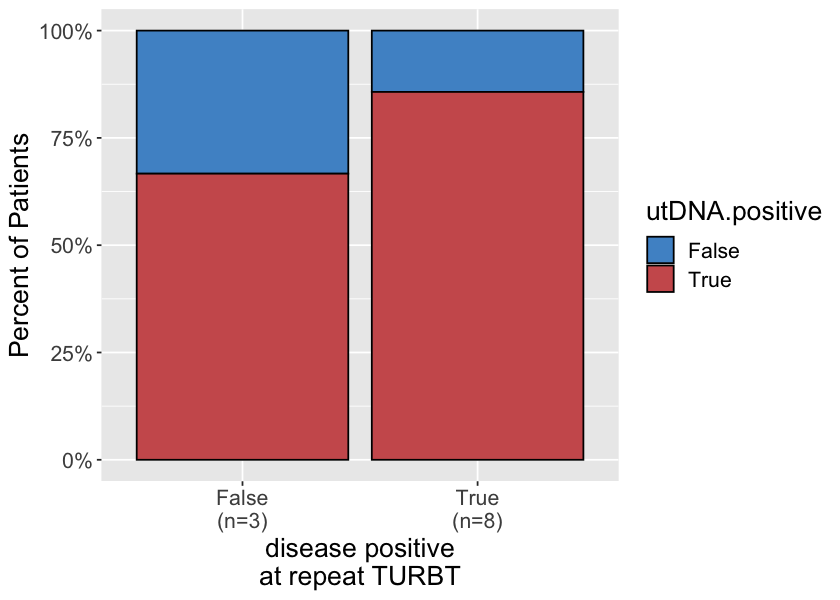

In [30]:
## correlation of mrd.status pipeline call with disease positivity
options(repr.plot.width=7, repr.plot.height=5)

ggplot(df_mrd_pre) +
  geom_bar(aes(x=factor(disease.positive), fill=factor(mrd.status)), position="fill", color="black") +
  scale_y_continuous(labels = scales::percent) +
  scale_fill_manual(name = "utDNA.positive", labels=c("False","True"), values=c("steelblue3", "indianred")) +
  scale_x_discrete(labels=c("False\n(n=3)","True\n(n=8)")) +
  labs(y="Percent of Patients", x="disease positive\nat repeat TURBT") +
  theme(text = element_text(size = 16))

mat = matrix(c(3,1,5,2), nrow=2, byrow=TRUE)
print(mat)
fisher.test(mat)

In [46]:
# function for sens and spec
options(repr.plot.width=5, repr.plot.height=5)

get_sens_spec <- function(df, label_col, score_col, title=NA, thresh=NA, target_sens=NA){
    print(label_col %in% names(df))
    print(score_col %in% names(df))
    print(sum(!is.na(df[[score_col]])))
    df = df %>% rename("label"={{label_col}}, "score"={{score_col}}) %>% mutate("label"=as.character(label))
    print(glue("number of NA labels: {sum(is.na(df$label))}"))
    print(sprintf("case/control: %s / %s", sum(df$label=="TRUE"), sum(df$label=="FALSE")))
    
    if (!is.na(thresh)){
      TP = nrow(df %>% filter(label=="TRUE", score >= thresh))
      FN = nrow(df %>% filter(label=="TRUE", score < thresh))
      TN = nrow(df %>% filter(label=="FALSE", score < thresh))
      FP = nrow(df %>% filter(label=="FALSE", score >= thresh))
      sens = TP/(TP + FN)
      spec = TN/(TN + FP)
      print(paste("Threshold Sens:", sens))
      print(paste("Threshold Spec:", spec))
        }
    
    pROC_obj <- roc_(data=df, response="label", predictor="score", 
                     smooth = FALSE, plot=FALSE, direction="<") # controls score lower than cases
    if (!is.na(title)){
       plot.roc(pROC_obj, auc.polygon=TRUE, max.auc.polygon=FALSE, grid=TRUE, 
                #ci = TRUE, ci.type = "bars", #ci.type=c("bars", "shape", "no")
                print.auc=TRUE, show.thres=TRUE, main=title)
    }
    print(coords(pROC_obj, x="best"))
    
    if (!is.na(target_sens)){
        print(sprintf("target sens %s", target_sens))
        print(coords(pROC_obj, x=target_sens, input="sensitivity", 
                     ret=c("threshold","specificity", "sensitivity")))
        }
    print(paste0("AUC: ", auc(pROC_obj)))
}

Complete cases tf.m.f by disease.positive: 10
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.000344059075456777
TRUE median: 0.0194970056188002

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 3.5, p-value = 0.1373
alternative hypothesis: true location shift is not equal to 0

  disease.positive    tf.m.f   label
1            FALSE 0.5741412 p=0.137
2             TRUE        NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
[1] TRUE
[1] TRUE
[1] 10
number of NA labels: 0
[1] "case/control: 7 / 3"


Setting levels: control = FALSE, case = TRUE



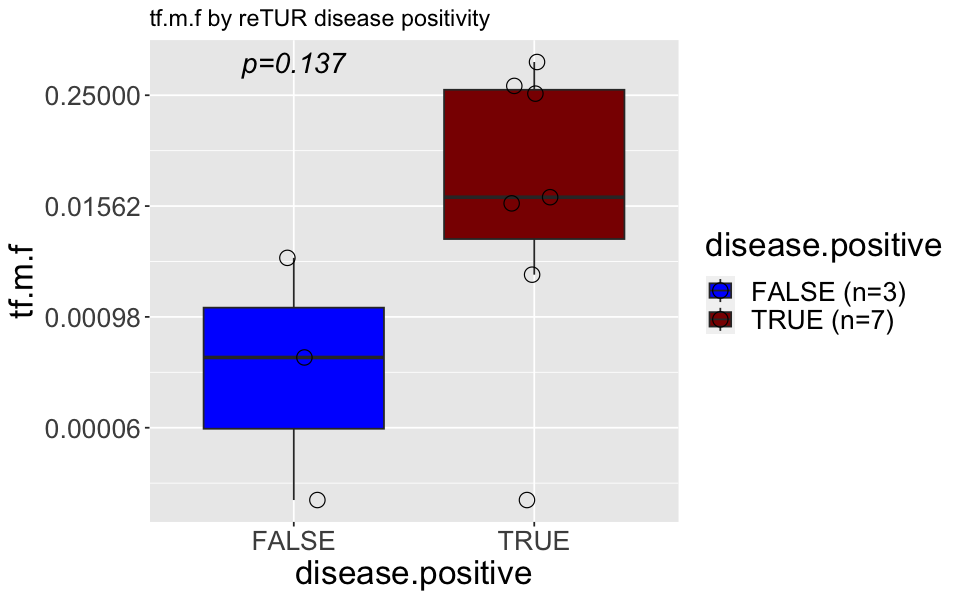

   threshold specificity sensitivity
1 0.01048709           1   0.7142857
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.833333333333333"
Complete cases tumorFraction by disease.positive: 10
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             7     TRUE (n=7)  darkred
FALSE median: 0.000502795355321168
TRUE median: 0.162535748331745

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 3.5, p-value = 0.1373
alternative hypothesis: true location shift is not equal to 0

  disease.positive tumorFraction   label
1            FALSE     0.6641799 p=0.137
2             TRUE            NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
[1] TRUE
[1] TRUE
[1] 10
number of NA labels: 0
[1] "case/control: 7 / 3"


Setting levels: control = FALSE, case = TRUE



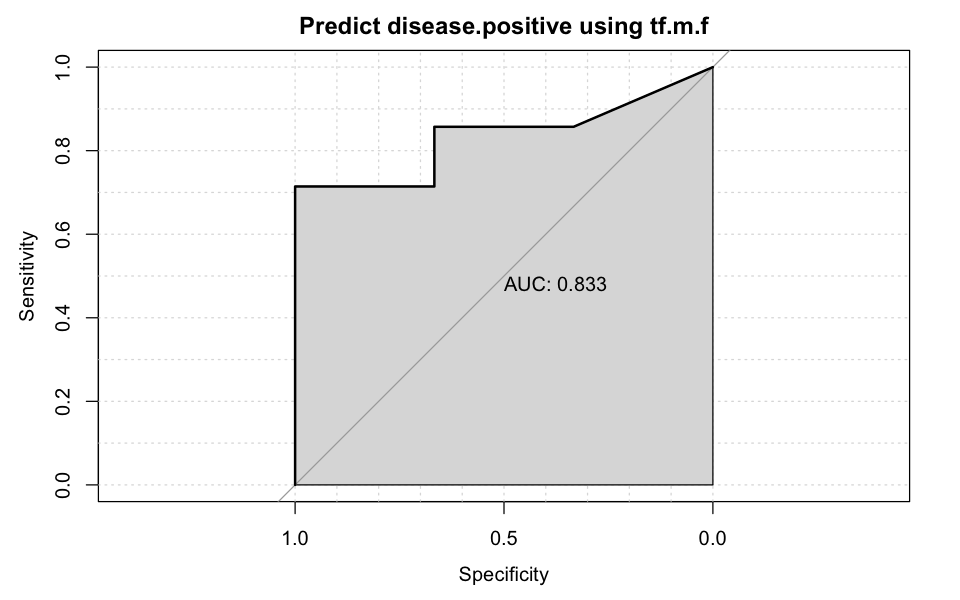

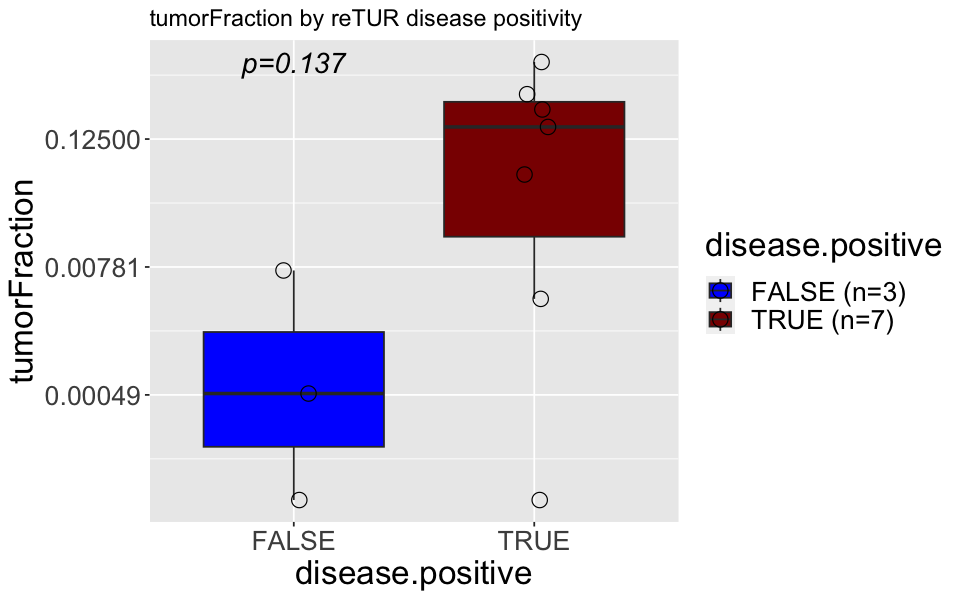

   threshold specificity sensitivity
1 0.03260299           1   0.7142857
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.833333333333333"


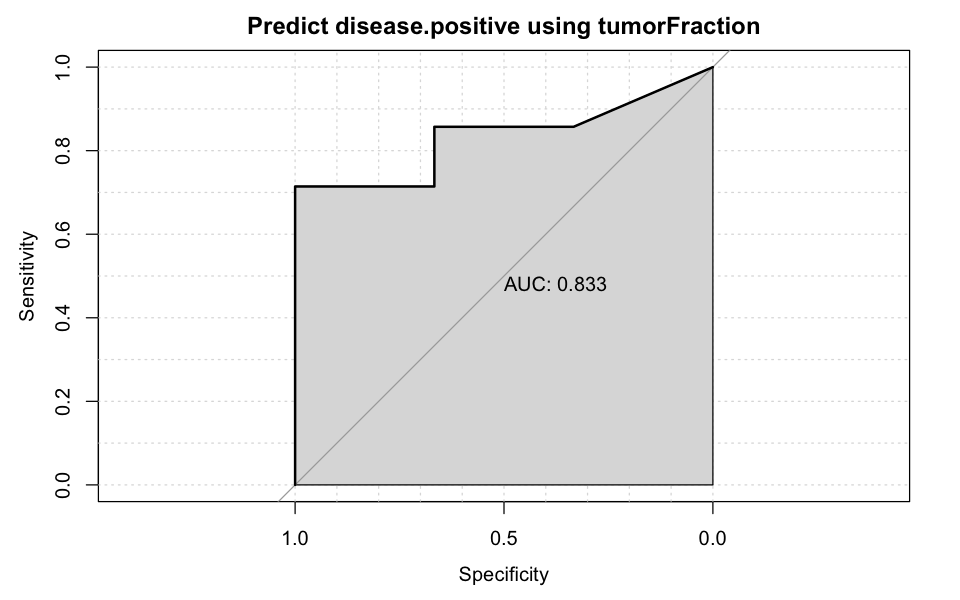

In [98]:
# correlation of MRD tumor fraction with disease positivity and prediction AUCs - 10 patients
source("~/Desktop/puffin/R/helper_functions.R")

df_mrd_pre$log_tumorFraction = log(df_mrd_pre$tumorFraction*100) 
#View(quick_boxplot)
df_mrd_pre = df_mrd_pre %>% mutate("disease.positive"=factor(disease.positive))
#pdf("./NMIBC_ucfDNA_BEACON_tumorFraction_boxplot_08042023.pdf", onefile = TRUE)

for (stat in c('tf.m.f','tumorFraction'#,'log_tumorFraction'#,
               #'tf.f','tf.ext.f','maf','tf.baseline','maf.baseline','tumorfraction.baseline',
               #'tumorfraction.baseline.adj','fc.tf.f','fc.tf.m.f','fc.tf.ext.f','tumorFraction')
              )){
    g <- quick_boxplot(df_mrd_pre, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = TRUE, log.0.adj=0.00001, plot.title = glue("{stat} by reTUR disease positivity"))
    options(repr.plot.width=8, repr.plot.height=5)
    show(g)
    #options(repr.plot.width=5, repr.plot.height=5)
    get_sens_spec(df_mrd_pre, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease.positive using {stat}"))
}
#dev.off()

In [6]:
## sumarize urine beacon # rerun
## number of baseline probes, # number of probes conf. detected 
    # mrd score # number new mutations detected #urine tumorFraction without new muts ## tumroFrac with new muts.
#select("PatientID","SampleID","SampleType","StudyVisit","has.IndexTURBT","has.repeatTURBT",
#                                "IndexPTStage","Repeat.Stage","disease.positive","utDNA.positive","tumorFraction_0")
mrd.table = df_mrd_pre %>% rename("N.baseline.muts.detected.mrdInfo"=mutationCount,
                                  "N.personal.probes.detected.mrdInfo"=mutationCount.mrd,
                                  "N.probes.detected.dynamic.mrdInfo"=mutationCount.mrd.f,
                                  "MRD.score"=mrd.score,
                                  "MRD.call"=mrd.status,
                                  "TF.all.muts.mrdInfo"=tumorfraction.baseline,
                                  "TF.dynamic.muts.mrdInfo"=tumorfraction.baseline.adj,
                                  "TF.dynamic.highqual.muts.mrdInfo"=tumorFraction) %>% 
               select(SampleID.short, PatientID, SampleType, StudyVisit, 
                      #"N.baseline.muts", #extract this one
                      N.baseline.muts.detected.mrdInfo, 
                      #"N.personal.probes", #extract this one
                      N.personal.probes.detected.mrdInfo, 
                      MRD.score, MRD.call,
                      TF.dynamic.muts.mrdInfo, 
                      TF.dynamic.highqual.muts.mrdInfo)
mrd.table

SampleID.short,PatientID,SampleType,StudyVisit,N.baseline.muts.detected.mrdInfo,N.personal.probes.detected.mrdInfo,MRD.score,MRD.call,TF.dynamic.muts.mrdInfo,TF.dynamic.highqual.muts.mrdInfo
<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<lgl>,<dbl>,<dbl>
P219768,173362,Urine,Pre-Repeat TURBT,2,2,1.00,FALSE,0.281,0.0000000000
P219770,172229,Urine,Pre-Repeat TURBT,72,64,8.75,TRUE,0.643,0.6641799480
P219771,173334,Urine,Pre-Repeat TURBT,72,70,68.50,TRUE,0.676,0.0039131614
P219774,171769,Urine,Pre-Repeat TURBT,42,35,2.50,TRUE,0.685,0.2373843811
P217590,172851,Urine,Pre-Repeat TURBT,39,36,9.25,TRUE,0.677,0.1625357483
P217591,172586,Urine,Pre-Repeat TURBT,27,29,2.50,TRUE,0.705,0.3306003890
P217592,173983,Urine,Pre-Repeat TURBT,40,36,36.00,TRUE,0.683,0.0579642593
P217594,169558,Urine,Pre-Repeat TURBT,33,30,31.50,TRUE,0.380,0.0072417228
P217595,161922,Urine,Pre-Repeat TURBT,38,36,29.00,TRUE,0.702,0.0005027954


In [78]:
# refine tumor fraction plots # rerun with lod=0.0005
options(repr.plot.width=7, repr.plot.height=7)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)

df_mrd_pre$log_tumorFraction_pct = log(df_mrd_pre$tumorFraction*100) 
min(df_mrd_pre$tumorFraction)
min(df_mrd_pre$log_tumorFraction_pct)


# log scale plot
# pdf("./NMIBC_ucfDNA_BEACON_log_tumorFraction_pct_boxplot_03032023.pdf")
# ggplot(df_mrd_pre, aes(x=factor(disease.positive), y=log_tumorFraction_pct, fill=factor(disease.positive))) +
#   geom_boxplot(outlier.shape = NA) +
#   geom_point(position=position_jitterdodge(), size=4, pch=1) +
#   #scale_y_continuous(labels = scales::percent) +
#   scale_fill_manual(name = "disease.positive", labels=c("False (n=3)","True (n=8)"), values=c("blue","darkred")) +
#   labs(y="log percent ucfDNA Tumor Fraction", x="") +
#   #ylim(min(df_mrd_pre$log_tumorFraction) - 0.1,4.5) +
#   theme(text = element_text(size = 20), axis.ticks = element_blank(), 
#         axis.text.x = element_blank())
# dev.off()

# # normal plot signif
# print("as percentages")
# print(mean(df_mrd_pre$tumorFraction_pct[df_mrd_pre$disease.positive==FALSE], na.rm=T))
# print(mean(df_mrd_pre$tumorFraction_pct[df_mrd_pre$disease.positive==TRUE], na.rm=T))
# res <- wilcox.test(tumorFraction_pct ~ factor(disease.positive),
#                    data = df_mrd_pre,
#                    exact = FALSE)
# res

# # remove outlier
# df_mrd_pre_ = df_mrd_pre %>% filter(tumorFraction<0.40)
# print(mean(df_mrd_pre_$tumorFraction[df_mrd_pre_$disease.positive==FALSE], na.rm=T))
# print(mean(df_mrd_pre_$tumorFraction[df_mrd_pre_$disease.positive==TRUE], na.rm=T))
# res <- wilcox.test(tumorFraction ~ factor(disease.positive),
#                    data = df_mrd_pre_,
#                    exact = FALSE)
# res

[1] 5e-05

[1] -5.298317

## power calculations

In [83]:
# power calc for validation cohort - 
# to detect significant difference in median tumor fraction between disease.positive/disease.negative at reTUR
# power curve: Significance vs. sample size given obsv. effect size
# https://cinnipatel.medium.com/power-curve-in-r-8a1e67fb2600

library(WMWssp)
# how many samples required to have 80% power to detect given effect size with confidence alpha=0.01 (p val, FPR)
plot_MWU <- function(case_vals, control_vals, power, metric=""){
    x = case_vals[!is.na(case_vals)]
    y = control_vals[!is.na(control_vals)]
    #effect_size = round(((mean(x) - mean(y))/mean(y)) * 100, 1)  #pct avg decrease from disease.positive to disease.nge
    effect_size = round((median(x) - median(y)), 3)
    print(effect_size)
    sig.level.list <- seq(.01,0.10,.01)  #Vector of sig..level 
    samp.out <- NULL
    for(a in sig.level.list){
      ssp <- WMWssp(x , 
                  y,
                  alpha = a, 
                  power = power, 
                  t = 7/10, 
                  simulation=T, nsim=100)
      res = summary(ssp)
      n.xxx  <-  res$Results[[9]]
      print(n.xxx)
      n.xxx <- data.frame(sig.level=a, sample.size=n.xxx)
      samp.out <- rbind(samp.out,n.xxx)
    }
    gg <- ggplot(samp.out, aes(sample.size,sig.level))+
      geom_line() + theme(text=element_text(size=15)) +
      #theme_minimal() +
      geom_hline(yintercept = .05,lty=2, color='blue') +
      geom_point() +
      labs(title=sprintf("Wilcoxon test, power=0.80\n%s = %s", metric, effect_size),
           y="Significance Level (p-value)",
           x="Sample size")
    show(gg)
    return(samp.out)
    }

[1] 0.019
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9800000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


[1] 0.162
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9700000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9400000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

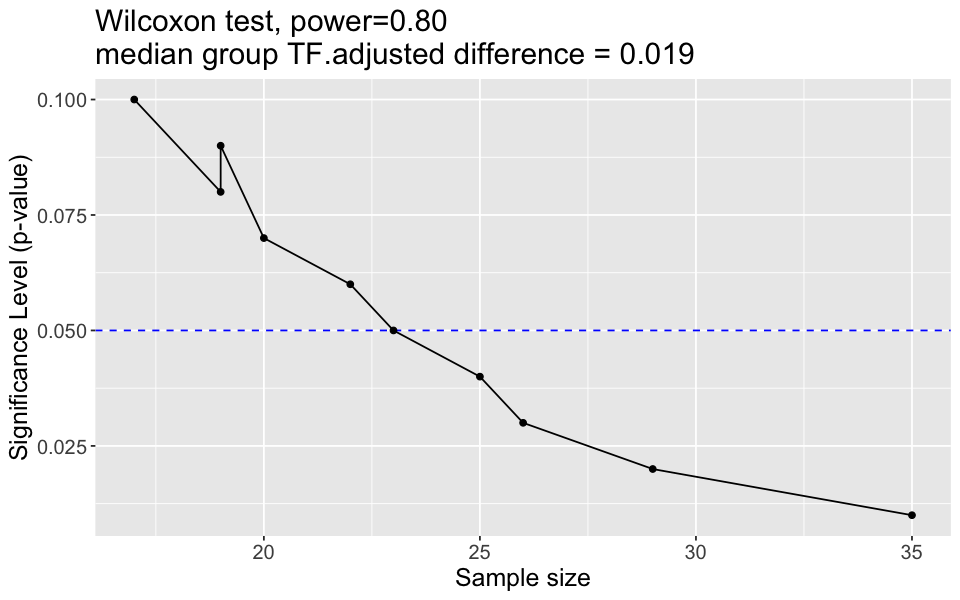

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


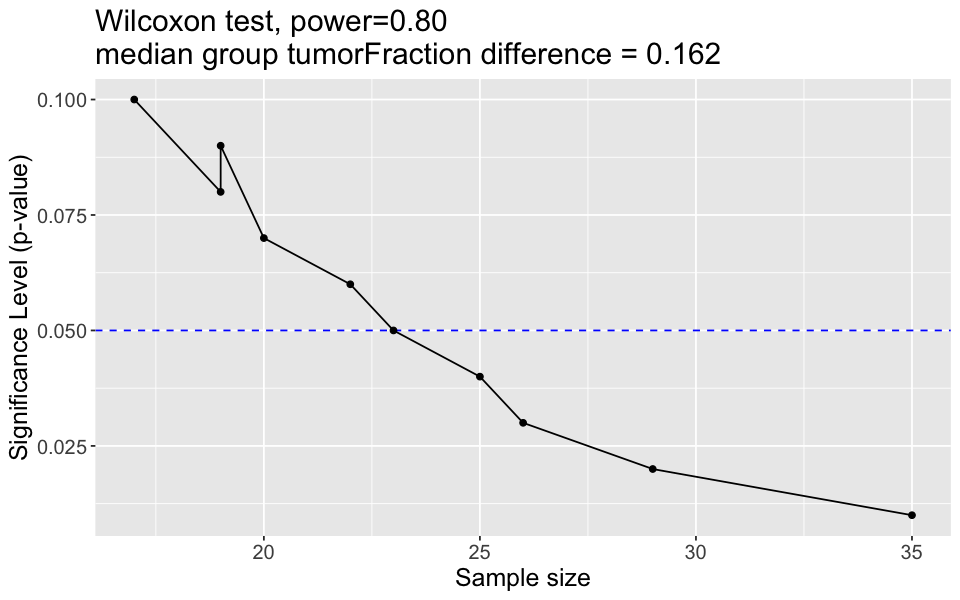

In [88]:
## BEACON tumorFraction measures
plot_MWU(df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group TF.adjusted difference")

plot_MWU(df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group tumorFraction difference")

[1] 0.055
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.1428571
N (total sample size needed) 27.1327432
t=n1/N                        0.7000000
n1 in Group 1                18.9929202
n2 in Group 2                 8.1398229
N rounded                    28.0000000
n1 rounded                   19.0000000
n2 rounded                    9.0000000
[1] 28
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9200000
Estimated relative effect p   0.1428571
N (total sample size needed) 22.8659188
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,28
0.02,24
0.03,22
0.04,20
0.05,19
0.06,17
0.07,16
0.08,16
0.09,15


[1] 0.109
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                               Results
alpha (2-sided)               0.010000
Power                         0.800000
Simulated Power               0.970000
Estimated relative effect p   0.177381
N (total sample size needed) 31.113570
t=n1/N                        0.700000
n1 in Group 1                21.779499
n2 in Group 2                 9.334071
N rounded                    32.000000
n1 rounded                   22.000000
n2 rounded                   10.000000
[1] 32
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                               Results
alpha (2-sided)               0.020000
Power                         0.800000
Simulated Power               0.950000
Estimated relative effect p   0.177381
N (total sample size needed) 26.238465
t=n1/N                     

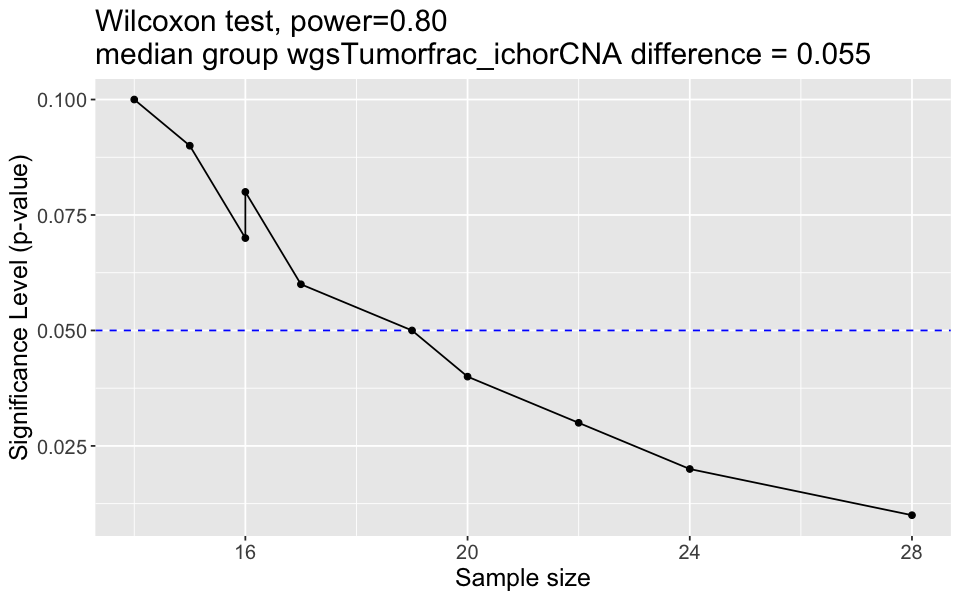

sig.level,sample.size
<dbl>,<dbl>
0.01,32
0.02,27
0.03,25
0.04,22
0.05,20
0.06,19
0.07,19
0.08,17
0.09,17


[1] 4.065
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                              Results
alpha (2-sided)               0.01000
Power                         0.80000
Simulated Power               0.99000
Estimated relative effect p   0.10000
N (total sample size needed) 21.87137
t=n1/N                        0.70000
n1 in Group 1                15.30996
n2 in Group 2                 6.56141
N rounded                    23.00000
n1 rounded                   16.00000
n2 rounded                    7.00000
[1] 23
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                              Results
alpha (2-sided)               0.02000
Power                         0.80000
Simulated Power               0.94000
Estimated relative effect p   0.10000
N (total sample size needed) 18.35170
t=n1/N                        0.70000
n1 in G

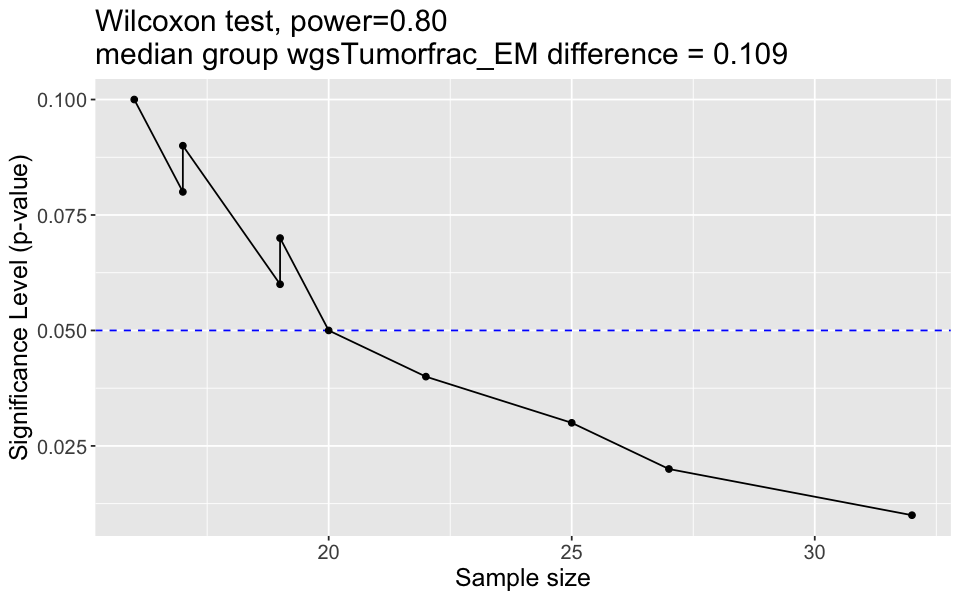

sig.level,sample.size
<dbl>,<dbl>
0.01,23
0.02,19
0.03,17
0.04,16
0.05,15
0.06,13
0.07,13
0.08,12
0.09,12


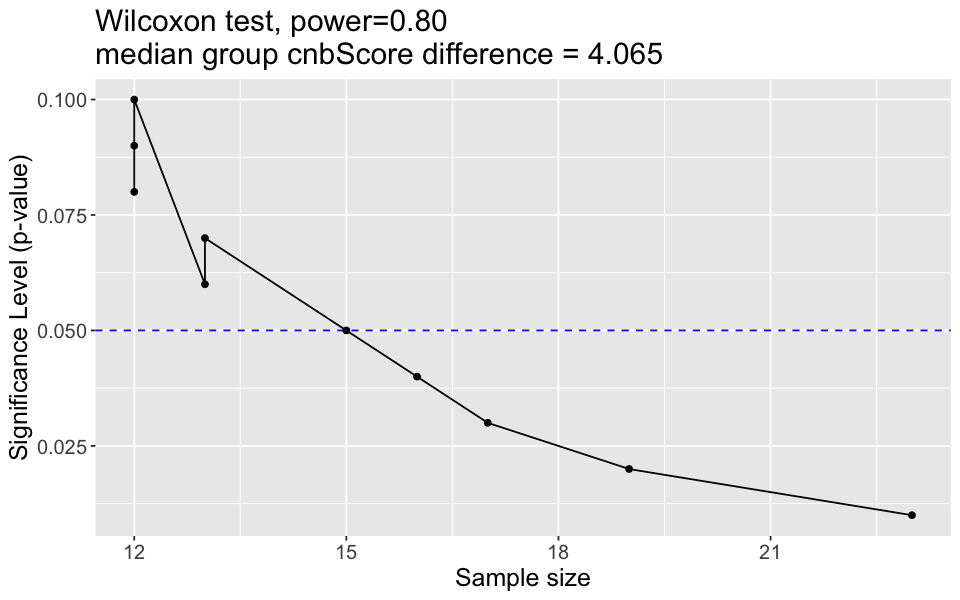

In [89]:
# LPWGS power
plot_MWU(df_urine_lpwgs_pre$wgsTumorfrac_ichorCNA[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$wgsTumorfrac_ichorCNA[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_ichorCNA difference")

plot_MWU(df_urine_lpwgs_pre$wgsTumorfrac_EM[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$wgsTumorfrac_EM[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_EM difference")

plot_MWU(df_urine_lpwgs_pre$cnbScore[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$cnbScore[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group cnbScore difference")

## LPWGS pre-repeat urine analysis

In [67]:
# batch 1 + 2   ## panel needs TMB update
# batch 1+2: 15 total, patients 11 and 18 did not have enough FFPE for processing, 2 failed
# ffpe 50X WGS
df_ffpe_lpwgs_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/LPWGS/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                                    "samples", warn=F)
df_ffpe_lpwgs_a$PatientID <- fix_PIDs(df_ffpe_lpwgs_a$PatientID)
# urine LPWGS 
df_urine_lpwgs_a1 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                             "samples", warn=F)
df_urine_lpwgs_a1$PatientID <- fix_PIDs(df_urine_lpwgs_a1$PatientID)
#df = df_all_a %>% filter(SampleType=="Supernatant") %>% filter(SampleID.short %!in% df_urine$SampleID.short)
# print(df)  # found missing samples in a2 below, bam files had been moved
# write.csv(df, "./missing_CNB_NMIBC_urine_samples.csv", row.names=F)
df_urine_lpwgs_a2 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_lpwgsQC_missing_05092023.csv", 
                                               as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")), "samples", warn=F)
df_urine_lpwgs_a2$PatientID <- fix_PIDs(df_urine_lpwgs_a2$PatientID)
df_all_lpwgs_a = rbind.common(df_ffpe_lpwgs_a, rbind.common(df_urine_lpwgs_a1, df_urine_lpwgs_a2))

# batch 3
# no low pass seq data for ffpes yet
# urine samples, low pass only, mrd TBD
df_urine_lpwgs_b = read.csv("./data_batch3_02222023/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all.csv") %>%
                mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix"))
df_urine_lpwgs_b$PatientID <- fix_PIDs(df_urine_lpwgs_b$PatientID)

## combine batches
df_lpwgs_all = rbind.common(df_all_lpwgs_a, df_urine_lpwgs_b)
df_lpwgs_all = merge.combine(df_lpwgs_all, df_qc_all %>% select(PatientID, SampleID.short, SampleType, StudyVisit)) %>%
                left_join(df_clin %>% select("PatientID","disease.positive"), by="PatientID") %>%
                mutate("disease.positive"=factor(disease.positive))
stopifnot(all(!duplicated(df_lpwgs_all$SampleID.short)))
nrow(df_lpwgs_all) # 103
unique(df_lpwgs_all$SampleType)
unique(df_lpwgs_all$StudyVisit)

SampleID.short format: remove.suffix
 [1] "172229" "172586" "172602" "169558" "172851" "173334" "171769" "172530"
 [9] "173362" "173509" "161922" "173983"
SampleID.short format: remove.suffix
 [1] "172586" "173359" "169558" "161922" "172530" "173362" "172153" "172229"
 [9] "173334" "171374" "171769"
SampleID.short format: remove.suffix
 [1] "169558" "161922" "172530" "172602" "172851" "172586" "173983" "173359"
 [9] "173334" "171374" "173509" "171769"
SampleID.short format: remove.suffix
 [1] "175492" "152237" "173350" "175725" "171821" "174083" "182022" "174872"
 [9] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[17] "174947" "174091" "176828" "180264" "172749" "175325" "173281" "173075"
[25] "116381" "165028" "167162" "175648" "173254" "175610" "176992" "175526"
[33] "175733" "175387"


[1] 103

[1] "Tissue" "Urine"

[1] "IndexTURBT"       "RepeatTURBT"      "Post TURBT"       "Surveillance 1"  
[5] "Pre-Repeat TURBT" "Follow Up 1"

In [70]:
df_urine_lpwgs_pre = df_lpwgs_all %>% filter(StudyVisit=="Pre-Repeat TURBT", SampleType=="Urine")
nrow(df_urine_pre) # 44
# df = df_urine_pre %>% 
#     select(PatientID, StudyVisit, disease.positive, wgsTumorfrac_ichorCNA) %>% arrange(PatientID)
# write.csv(df, "./pre_repeat_urine_WGS_TF_list.csv", row.names=F)
source("~/Desktop/puffin/R/helper_functions.R")

[1] 44

In [81]:
df_urine_lpwgs_pre

SampleID,Total.reads..M.,Mapped.reads..M.,Mapping.rate....,Consensus.reads..M.,Duplication.rate....,Fragment_Size_Mode,Softclip.ratio,ProjectDir,coveredGenomicPect,coverage,qcLabel,gender,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,classificationLabel,binNum,cnvbinNum,cnabinNum,cnlbinNum,cnvbinRatio,neutbinNum,neutbinRatio,wgsTumorfrac_EM,externalSampleID,SampleID.short,SampleType,StudyVisit,PatientID,disease.positive
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<fct>
P219768_WGS,112.0,112.0,99.9,56.1,49.9,96.0,0.1560,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC/bamfiles,91.2,1.81,Pass,male,0.0259,60.137,1843520,5.298889,lowRisk,2330,68,46,22,0.029,440,0.189,0.00000000,06S22025115,P219768,Urine,Pre-Repeat TURBT,173362,TRUE
P219769_WGS,65.2,65.1,99.9,35.8,45.0,157.0,0.0764,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC/bamfiles,91.2,1.61,Pass,male,0.3847,1139.441,1662373,10.236416,highRisk,2328,1367,598,769,0.587,893,0.384,0.67340584,06S22019729,P219769,Urine,Pre-Repeat TURBT,172153,TRUE
P219770_WGS,79.6,78.2,98.2,47.2,39.6,171.0,0.0816,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC/bamfiles,94.6,2.34,Pass,female,0.1826,596.068,2394820,9.270623,highRisk,2330,881,482,399,0.378,964,0.414,0.20876577,06S22009423,P219770,Urine,Pre-Repeat TURBT,172229,TRUE
P217594_WGS,NA,NA,NA,NA,NA,126.0,0.0982,/prednet/data22/OutputByRun22/220902_A01832_0037_BHCKWTDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,91.4,1.89,Pass,male,0.0000,23.266,1936359,3.564916,lowRisk,2330,0,0,0,0.000,2330,1.000,0.00000000,06S22025472,P217594,Urine,Pre-Repeat TURBT,169558,FALSE
P217595_WGS,NA,NA,NA,NA,NA,123.0,0.0915,/prednet/data22/OutputByRun22/220902_A01832_0037_BHCKWTDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,93.9,2.03,Pass,male,0.0000,25.616,2066406,4.023014,lowRisk,2330,0,0,0,0.000,2329,1.000,0.00000000,06S22017945,P217595,Urine,Pre-Repeat TURBT,161922,FALSE
P217596_WGS,NA,NA,NA,NA,NA,143.0,0.0650,/prednet/data22/OutputByRun22/220902_A01832_0037_BHCKWTDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,95.1,2.08,Pass,male,0.0000,16.653,2134340,3.318286,lowRisk,2330,0,0,0,0.000,2330,1.000,0.00000000,06S22025295,P217596,Urine,Pre-Repeat TURBT,172530,FALSE
P217589_WGS,NA,NA,NA,NA,NA,130.0,0.0900,/prednet/data22/OutputByRun22/220902_A01832_0038_AHCL3TDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,93.5,1.96,Pass,male,0.0723,350.385,2009706,8.556148,highRisk,2330,469,283,186,0.201,483,0.207,0.19993341,06S22017869,P217589,Urine,Pre-Repeat TURBT,172602,TRUE
P217590_WGS,NA,NA,NA,NA,NA,138.0,0.1060,/prednet/data22/OutputByRun22/220902_A01832_0038_AHCL3TDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,93.9,2.01,Pass,male,0.1427,812.660,2015010,9.686186,highRisk,2330,1167,666,501,0.501,656,0.282,0.43065468,06S22022824,P217590,Urine,Pre-Repeat TURBT,172851,TRUE
P217591_WGS,NA,NA,NA,NA,NA,117.0,0.0898,/prednet/data22/OutputByRun22/220902_A01832_0038_AHCL3TDSX5/dsrun1.7.0/lbwfresult1.7.0/WGS_WOP00254_PRDC-MOFFITT-NMIBC-22001,94.6,1.98,Pass,male,0.3565,923.380,2068380,9.927298,highRisk,2330,1108,366,742,0.476,1150,0.494,0.30777752,06S22017463,P217591,Urine,Pre-Repeat TURBT,172586,TRUE


Complete cases wgsTumorfrac_ichorCNA by disease.positive: 44
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            14    FALSE (n=14) blue   
2 TRUE             30    TRUE (n=30)  darkred
FALSE median: 0
TRUE median: 0.05525

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 60, p-value = 0.0001043
alternative hypothesis: true location shift is not equal to 0

  disease.positive wgsTumorfrac_ichorCNA    label
1            FALSE                0.4651 p=<0.001
2             TRUE                    NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
[1] TRUE
[1] TRUE
[1] 44
number of NA labels: 0
[1] "case/control: 30 / 14"


Setting levels: control = FALSE, case = TRUE



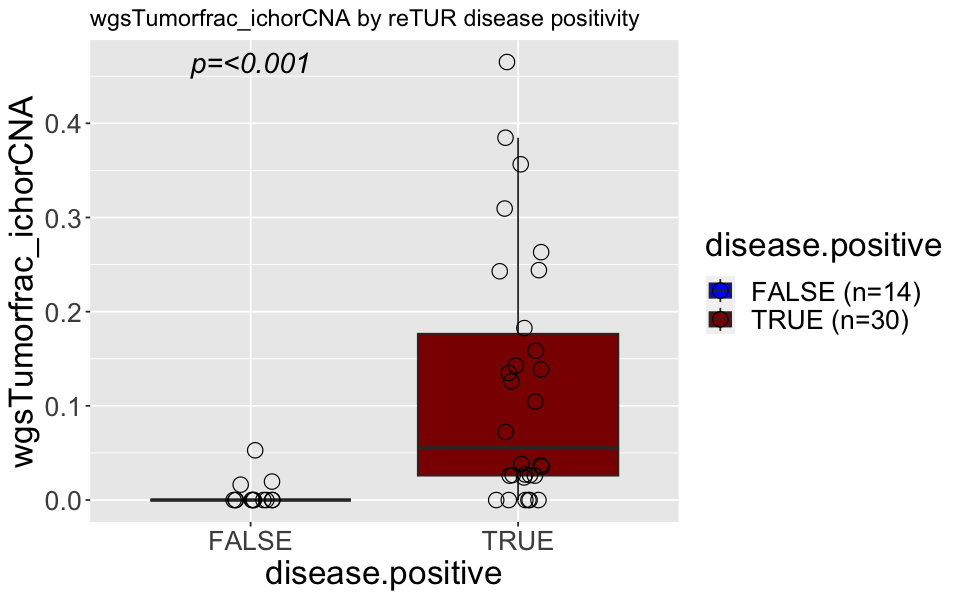

  threshold specificity sensitivity
1    0.0218   0.9285714         0.8
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.857142857142857"
Complete cases cnbScore by disease.positive: 44
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            14    FALSE (n=14) blue   
2 TRUE             30    TRUE (n=30)  darkred
FALSE median: 3.95436003024113
TRUE median: 8.01950005282747

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 42, p-value = 2.436e-05
alternative hypothesis: true location shift is not equal to 0

  disease.positive cnbScore    label
1            FALSE 10.80927 p=<0.001
2             TRUE       NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
[1] TRUE
[1] TRUE
[1] 44
number of NA labels: 0
[1] "case/control: 30 / 14"


Setting levels: control = FALSE, case = TRUE



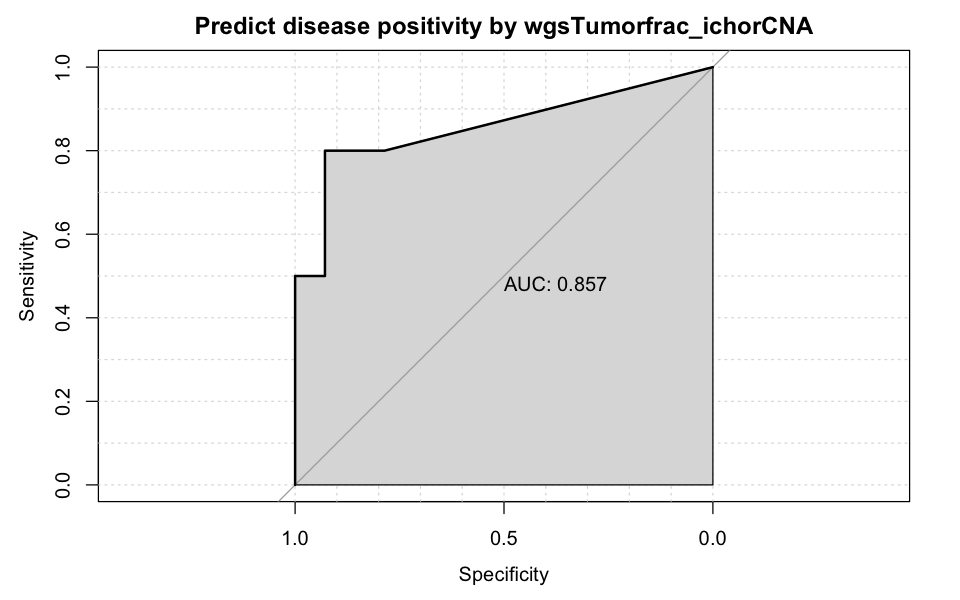

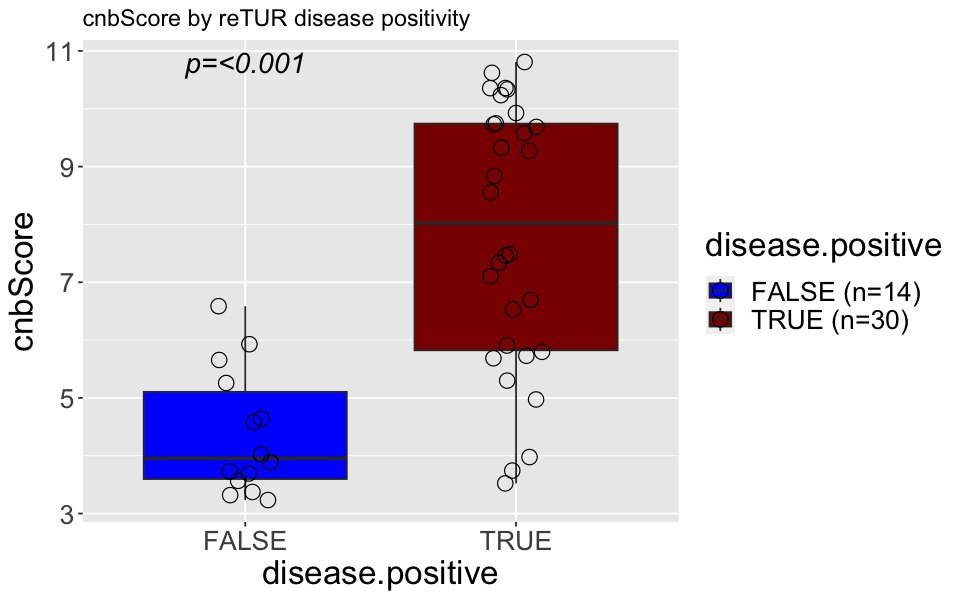

  threshold specificity sensitivity
1  5.670669   0.8571429   0.8333333
[1] "target sens 1"
  threshold specificity sensitivity
1  3.447388   0.2142857           1
[1] "AUC: 0.9"
Complete cases wgsTumorfrac_EM by disease.positive: 44
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            14    FALSE (n=14) blue   
2 TRUE             30    TRUE (n=30)  darkred
FALSE median: 0
TRUE median: 0.10874038682539

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 74.5, p-value = 0.0002767
alternative hypothesis: true location shift is not equal to 0

  disease.positive wgsTumorfrac_EM    label
1            FALSE       0.7317695 p=<0.001
2             TRUE              NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


NULL
[1] TRUE
[1] TRUE
[1] 44
number of NA labels: 0
[1] "case/control: 30 / 14"


Setting levels: control = FALSE, case = TRUE



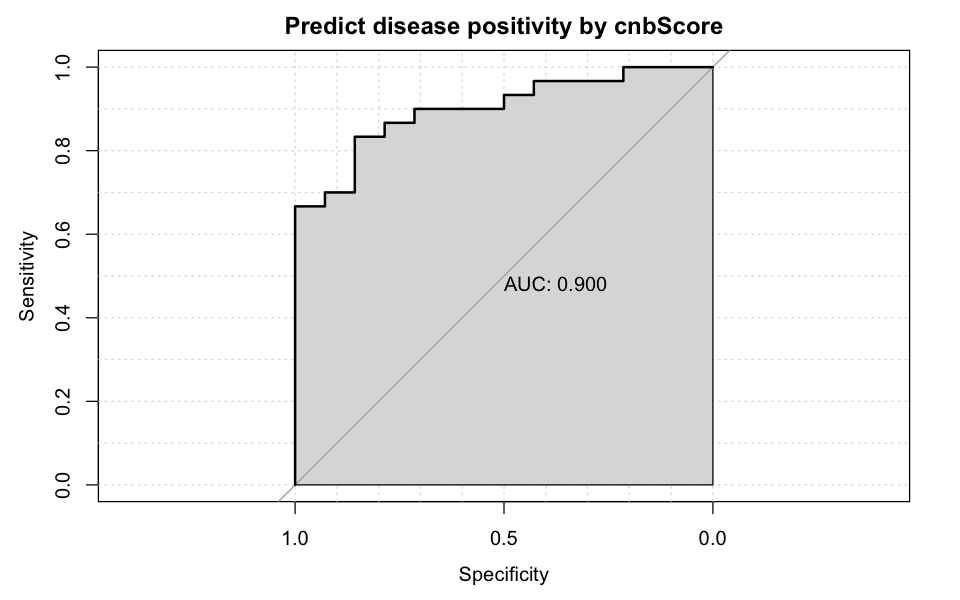

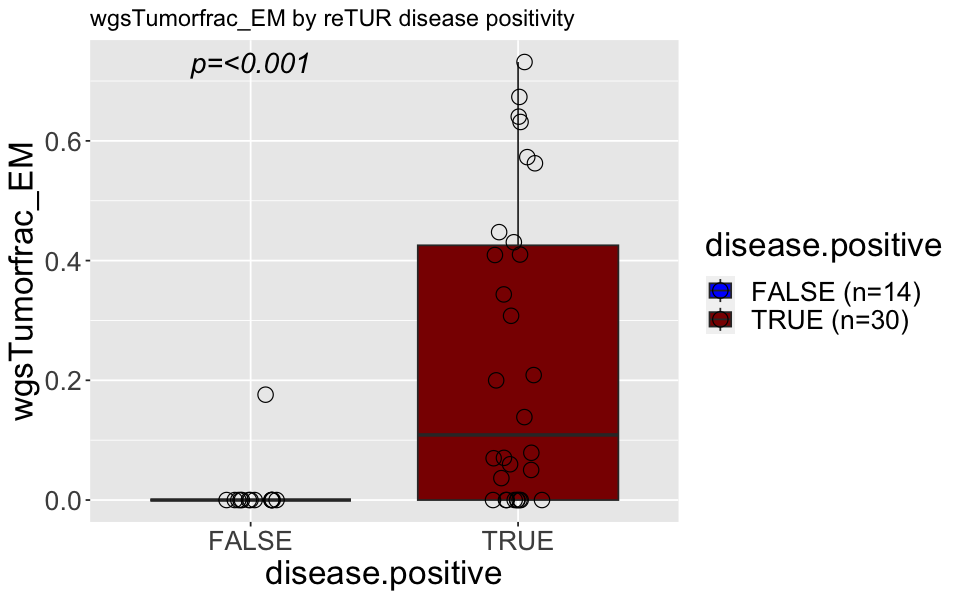

   threshold specificity sensitivity
1 0.01830617   0.9285714         0.7
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.822619047619048"


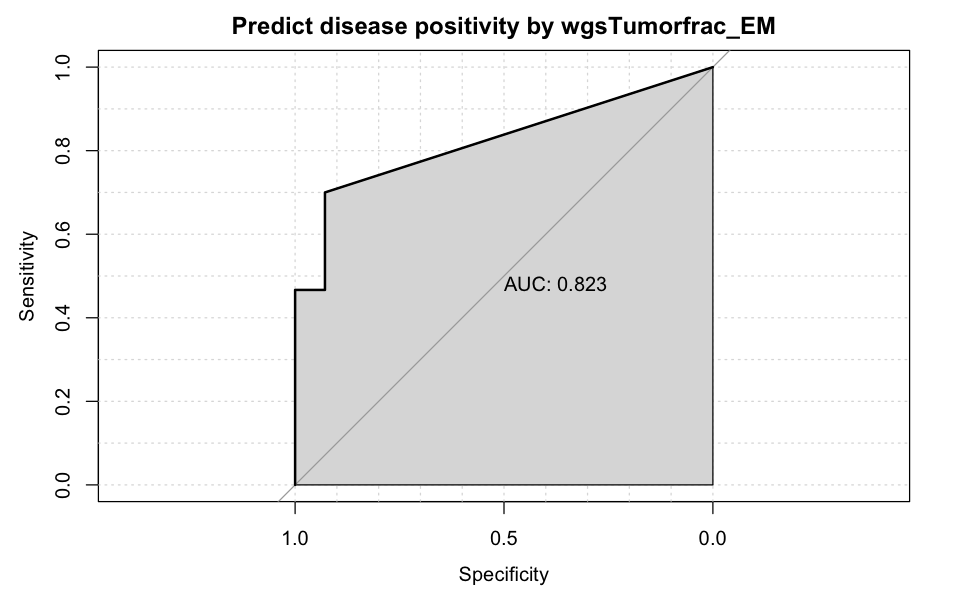

In [71]:
# correlation of LPWGS with disease positivity and prediction AUCs
for (stat in c('wgsTumorfrac_ichorCNA', 'cnbScore', 'wgsTumorfrac_EM')){
    options(repr.plot.width=8, repr.plot.height=5)
    g <- quick_boxplot(df_urine_lpwgs_pre, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = FALSE, plot.title = glue("{stat} by reTUR disease positivity"))
    show(g)
    get_sens_spec(df_urine_lpwgs_pre, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
}

In [ ]:
# ## format for ESMO abstract
# source("~/Desktop/puffin/R/helper_functions.R")
# #pdf("./data_batch3_02222023/urine_tissue_lpwgs_tumor_fraction_05092023.pdf")
# quick_boxplot(df = df_urine_pre %>% rename("WGS.Tumor.Fraction"="wgsTumorfrac_EM"),
#               x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
#              plot.title="Pre-repeat Urine WGS Tumor Fraction (EM)")

# quick_boxplot(df = df_urine_pre %>% rename("WGS.Tumor.Fraction"="wgsTumorfrac_ichorCNA"),
#               x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
#              plot.title="Pre-repeat Urine WGS Tumor Fraction (ichor)")

# quick_boxplot(df = df_urine_pre %>% rename("cnbScore"= "Copy Number Burden"),
#               x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
#              plot.title="Pre-repeat Urine WGS Tumor Fraction (ichor)")

#dev.off()

## hybrid baseline analysis

In [17]:
# samples for hybrid mrd
library(readxl)
library(dplyr)
samples = read_excel("./hybrid_probe_mrd/followup_samples_NMIBC.xlsx", sheet="Sheet1")
pids = c("171374",
"172602",
"173359",
"175492",
"175854",
"171821",
"172749",
"173075",
"173254",
"173281",
"174083",
"174947",
"175425",
"175648",
"175672",
"175725",
"176388",
"172229",
"172586",
"172851",
"171769",
"173362",
"176828")

samples = samples %>% mutate(PatientID=fix_PIDs(SubjectID.old))
samples = samples %>% filter(PatientID %in% pids, !duplicated(RequisitionID), SampleType!="UCP") %>% relocate(RequisitionID, DNAQC)

print(samples, n=1000)

New names:
• `` -> `...2`


 [1] "172602" "172851" "172586" "173359" "172229" "171769" "161922" "175725"
 [9] "171821" "175425" "176388" "176828" "173281" "173075" "174083" "174947"
[17] "172749" "175672"
# A tibble: 26 × 13
   RequisitionID DNAQC   SubjectID.old    ...2  StudyVisit  SampleType SampleVol
   <chr>         <chr>   <chr>            <lgl> <chr>       <chr>          <dbl>
 1 P217597       NA      NMIBC006         NA    Post TURBT  Urine           21.5
 2 P217598       NA      NMIBC010         NA    Post TURBT  Urine           20  
 3 P217599       NA      NMIBC005         NA    Post TURBT  Urine           10  
 4 P217600       NA      NMIBC018         NA    Post TURBT  Urine           17  
 5 P219777       NA      NMIBC003/MIBC021 NA    Post TURBT  Urine           41  
 6 P219781       NA      NMIBC014         NA    Post TURBT  Urine           50  
 7 P228744       PASS    175725           NA    Post TURBT  Urine           42  
 8 P228745       PASS    171821           NA    Post TURBT  Urine         

# tissue-based MRD analysis

In [64]:
# additional samples for tissue-based pre-repeatTURB urine MRD analysis
#library(readxl)
#library(dplyr)

# all samples recieved
all.samples = make_names(read_excel("Manifest_data_all_09122023.xlsx", sheet="Sample information real time")) # from FZ
names(all.samples)
sid.to.pid = all.samples$PatientID
names(sid.to.pid) <- all.samples$SampleID
#print(sid.to.pid)

# tissue-based probe order from Aug 2023 - PD labeled them as suffix "_1" in the pipeline
probe.counts.new = read.csv("tissue_probe_mrd/Personalized_Panels_received_20230828_Pooled_MRD_panelInfo_MOFFITT_FFPE_VIP/PRDC-MOFFITT-NMIBC-22001-B_MRD_Info_2023-07-07_ffpe.csv") %>%
    mutate(group="new")
names(probe.counts.new)
nrow(probe.counts.new)
# 37 patients

# urine based probe order from Dec 2022
# 4 urine-based probe sets for samples witout tumor tissue
# probe.counts.urine = read.csv("data_batch1_and_2/FFPE_WES/Peter_analysis _files/Peter_MRD_design_12172022/Personalized_NMIBC/WOP00344_WOP00370_WOP00393_PRDC-MOFFITT-NMIBC-22001_MRD_Info_2022-12-02.csv")
# probe.counts.urine = probe.counts.urine %>% mutate(PatientID=recode(SampleID, !!!sid.to.pid),
#                                                    group="urine")
# nrow(probe.counts.urine)# 4 (one failed)
# names(probe.counts.urine)

# 6 tissue-based probe sets from Dec 2022
probe.counts.tissue = read.csv("data_batch1_and_2/FFPE_WES/Peter_analysis _files/Peter_MRD_design_12172022/Personalized_NMIBC/WOP00249_WOP00250_PRDC-MOFFITT-NMIBC-22001_MRD_Info_2022-09-23.csv")
probe.counts.tissue = probe.counts.tissue %>% mutate(PatientID=recode(SampleID, !!!sid.to.pid),
                                                    group="tissue")
nrow(probe.counts.tissue) # 12

patients.w.probes <- c(probe.counts.new$PatientID, probe.counts.tissue$PatientID)
table(patients.w.probes, useNA="always") # 50 patients

all.probe.counts = rbind.common(probe.counts.tissue, probe.counts.new)
all.probe.counts = all.probe.counts %>% left_join(all.samples %>% select(SampleID, SampleType, StudyVisit), by="SampleID")

# duplicate probe libararies
# for now don't use library from RepeatTURBTs
all.probe.counts %>% filter(PatientID=="172229")
all.probe.counts %>% filter(PatientID=="173334")

# tissue or urine only based probes for pre-repeat urine mrd and post-repeat mrd
patients.w.probes <- unique(patients.w.probes)

samples.for.mrd = all.samples %>% filter(PatientID %in% patients.w.probes,
                                         StudyVisit=="Pre-Repeat TURBT",
                                         SampleType=="Supernatant",
                                        is.na(MRD)) # has not been MRD sequenced yet
dim(samples.for.mrd)
samples.for.mrd %>% arrange(PatientID) 
# 36 samples - unknown if any of these failed extraction QC. one sample is from batch1, did we seq this one already?
write.csv(samples.for.mrd, "tissue_probe_mrd/preRepeat_urine_samles_for_tissue_mrd.csv")

#available followup urine samples for these same patients - excluding those with urine-only baseline
# samples.for.mrd = all.samples %>% filter(PatientID %in% patients.w.probes,
#                                          !grepl("TURBT", StudyVisit, ignore.case=T),
#                                          SampleType=="Supernatant",
#                                         is.na(MRD))
# dim(samples.for.mrd) # 31 followup urine samples, 
# samples.for.mrd

[1] "Order_orig"          "Order_pt"            "externalSampleID"   
 [4] "PatientID"           "StudyVisit"          "SampleType"         
 [7] "Collection.Date_new" "Batch."              "Receive.Date"       
[10] "SampleID"            "EX...QC"             "EPIC"               
[13] "MRD"                 "WES."                "MRDprobe"

[1] "PatientID"         "Panel_Name"        "SampleID"         
[4] "VariantCount.good" "VariantCount"      "VariantCount.ext" 
[7] "probeCount"        "group"

[1] 37

[1] 12

patients.w.probes
116381 152237 161922 165028 167162 169558 171769 171821 172229 172530 172586 
     1      1      1      1      1      1      1      1      2      1      1 
172602 172749 172851 173075 173281 173334 173350 173362 173509 173912 173975 
     1      1      1      1      1      2      1      1      1      1      1 
173983 174083 174091 174872 174947 175325 175387 175425 175492 175526 175610 
     1      1      1      1      1      1      1      1      1      1      1 
175648 175672 175725 175733 175854 175980 176349 176388 176828 176992 177967 
     1      1      1      1      1      1      1      1      1      1      1 
178886 180264 182022   <NA> 
     1      1      1      0 

PatientID,SampleID,VariantCount,probeCount,group,SampleType,StudyVisit
<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
172229,P220068,60,60,tissue,Tissue,IndexTURBT
172229,P228845,68,62,new,FFPE,172229_RepeatTURBT


PatientID,SampleID,VariantCount,probeCount,group,SampleType,StudyVisit
<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
173334,P220076,60,60,tissue,Tissue,IndexTURBT
173334,P228852,51,62,new,FFPE,173334_RepeatTURBT


[1] 36 15

Order_orig,Order_pt,externalSampleID,PatientID,StudyVisit,SampleType,Collection.Date_new,Batch.,Receive.Date,SampleID,EX...QC,EPIC,MRD,WES.,MRDprobe
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dttm>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
262,NA,06S22030087,116381,Pre-Repeat TURBT,Supernatant,2022-03-24,3,2023-02-21,P228695,NA,WOP00634,NA,NA,NA
234,NA,06S22108264,152237,Pre-Repeat TURBT,Supernatant,2022-10-19,3,2023-02-21,P228667,NA,WOP00634,NA,NA,NA
263,NA,06S22034101,165028,Pre-Repeat TURBT,Supernatant,2022-04-06,3,2023-02-21,P228696,NA,WOP00634,NA,NA,NA
264,NA,06S22033395,167162,Pre-Repeat TURBT,Supernatant,2022-04-04,3,2023-02-21,P228697,NA,WOP00634,NA,NA,NA
242,NA,06S22003270,171821,Pre-Repeat TURBT,Supernatant,2022-01-10,3,2023-02-21,P228675,NA,WOP00634,NA,WOP00873,NA
17,26,06S22017869,172602,Pre-Repeat TURBT,Supernatant,2022-02-15,1,2022-06-08,P217589,ROPM0173,ROPM0176,NA,NA,NA
258,NA,06S22022670,172749,Pre-Repeat TURBT,Supernatant,2022-02-28,3,2023-02-21,P228691,NA,WOP00634,NA,WOP00873,NA
261,NA,06S22018333,173075,Pre-Repeat TURBT,Supernatant,2022-02-16,3,2023-02-21,P228694,NA,WOP00634,NA,WOP00873,NA
260,NA,06S22024491,173281,Pre-Repeat TURBT,Supernatant,2022-03-07,3,2023-02-21,P228693,NA,WOP00634,NA,WOP00873,NA
